Motivation:
`250311_blue_dos` experiments have too few exploration steps (30) to gather enough information to 
make a sound conclusion about the most valuable blocked/unblocked configuration. This task is made
more challenging by the noise and temporal bias in the relationship between the blocked/unblocked 
configuration and the OK response rate reported by the client.

The following experiments will be 10 times longer. Additionally, a low-rate DOS attack (a 'Shrew' 
attack) will be used to prevent a seg fault on the attacker's machine / make the attack easier to
sustain.

Attack:
- Shrew attack with an RPS of 100.
- Commenced *after 15 minutes of 'normal operation'*.

Policy:
- "blue -t 10.0 -f 0.8 -i 0.05 -s 5.0 -e 300"
- Exploration for 300 steps @ 10s per step = 50 mins

In [25]:

import plot_utils
from plot_utils import LogFile,LogFileType,Fig,Roller
import rolling_funcs

WINDOW_SECS=120.0
STRIDE_SECS=5.0

In [26]:

response_rollers = [
    Roller("OK rate", rolling_funcs.count_ok, rate=True),
    Roller("ERR rate", rolling_funcs.count_err, rate=True, kwargs={'linestyle':'--'}),
]
mean_roller = Roller('mean', rolling_funcs.mean)
packet_rate = Roller('rate', rolling_funcs.count_kleene_packets, rate=True)

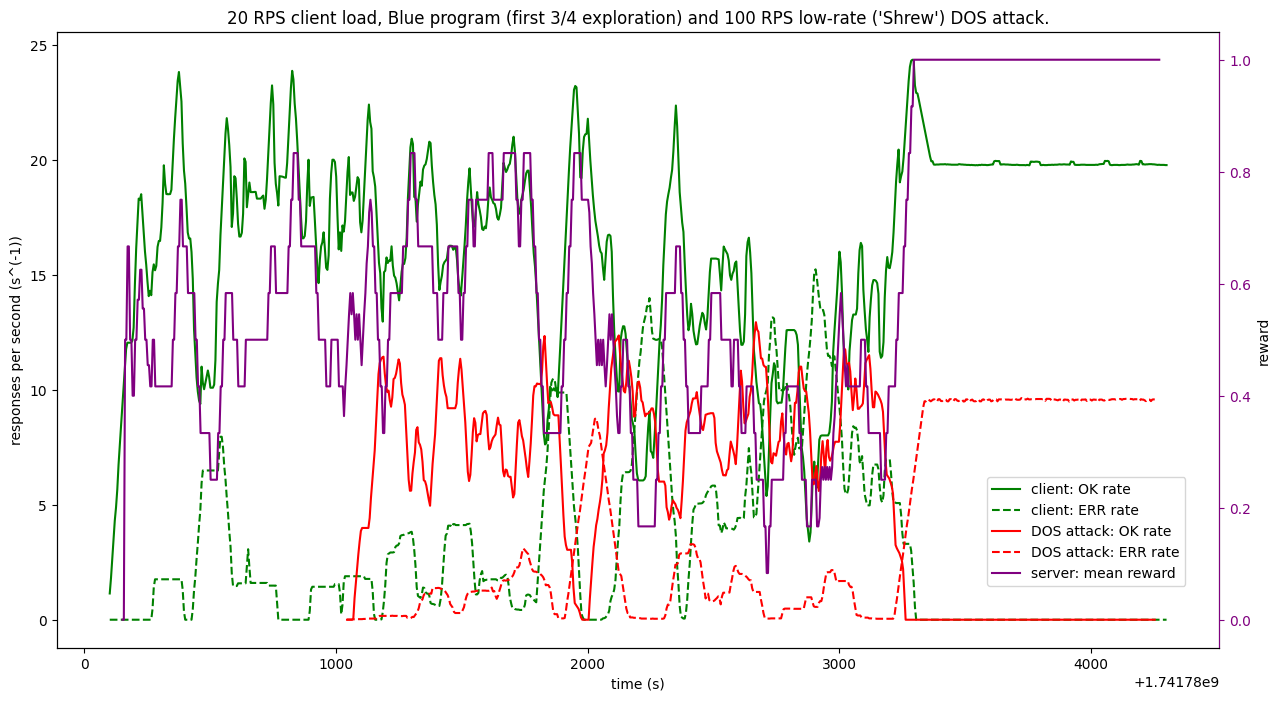

In [27]:
HILBERT="./logs/hilbert/2025-03-12_12:59:00.json"
HILBERT_BLUE="./logs/hilbert/2025-03-12_11-49-06.698847.txt"
KLEENE="./logs/kleene/2025-03-12_11-48-15.705410.txt"
KLEENE_TELEGRAF="./logs/kleene/2025-03-12_12:59:00.json"
MAC="./logs/mac/2025-03-12_12-03-58.705810.txt"

fig,ax = plot_utils.fig([Fig(title="20 RPS client load, Blue program (first 3/4 exploration) and 100 RPS low-rate ('Shrew') DOS attack.",x='time (s)',y='responses per second (s^(-1))')])

nginx_active = LogFile(log_type=LogFileType.TELEGRAF, path=HILBERT,
kwargs={'telegraf': {
    'nginx' : ['active', 'waiting']
}
})

client_mem = LogFile(log_type=LogFileType.TELEGRAF, path=KLEENE_TELEGRAF,
kwargs={'telegraf':{
    # 'mem' : ['used_percent','buffered','cached','vmalloc_used']
    'mem' : [{'used_percent':{'color':'gold'}}]
}})

client_log = LogFile(log_type=LogFileType.GOT, path=KLEENE,kwargs={'color':'g'})
shrew_log = LogFile(log_type=LogFileType.GOT, path=MAC,kwargs={'color':'r'})

blue_reward = LogFile(log_type=LogFileType.BLUE, path=HILBERT_BLUE,
kwargs={'states': [{'reward':{'color':'purple'}}]})

blue_ok_rate = LogFile(log_type=LogFileType.BLUE, path=HILBERT_BLUE,
kwargs={'states': ['ok_rate']})

# blue_actions = LogFile(log_type=LogFileType.BLUE, path=HILBERT_BLUE,
# kwargs={'actions': True
# })

ax_reward, = plot_utils.add_y_axes(
    ax, [('reward','purple'),]
)

# plot_utils.overlay_rolling(ax_active, {'server': nginx_active}, [mean_roller],WINDOW_SECS,times_units='s')
plot_utils.overlay_rolling(ax_reward, {'server': blue_reward}, [mean_roller],WINDOW_SECS, const_stride_secs=STRIDE_SECS, times_units='s')
# plot_utils.overlay_rolling(ax_mem, {'client': client_mem}, [mean_roller],WINDOW_SECS,times_units='s')
plot_utils.overlay_rolling(ax, {'client': client_log}, response_rollers, WINDOW_SECS, const_stride_secs=STRIDE_SECS, times_units='s')
# plot_utils.overlay_rolling(ax, {'server': blue_ok_rate}, [mean_roller],WINDOW_SECS, const_stride_secs=STRIDE_SECS, times_units='s')
plot_utils.overlay_rolling(ax, {'DOS attack': shrew_log}, response_rollers, WINDOW_SECS, const_stride_secs=STRIDE_SECS, times_units='s')

plot_utils.show_combined_legends([ax,ax_reward], loc=[0.8,0.1])
fig.savefig('./plots/20RPS_DOS_missing_attack_rps.png')

In [28]:
from blue import Blue
blue = Blue(HILBERT_BLUE)
end_of_exploration = (1.74178e9+3100) 
blue.stats(sorted=True,end_ns=end_of_exploration*1e9)

[('red_blocked', 71),
 ('none_blocked', 36),
 ('green_blocked', 24),
 ('both_blocked', 18)]

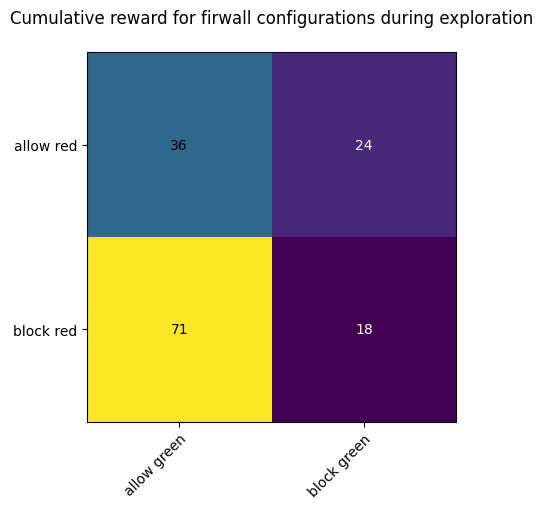

In [29]:
fig,ax = blue.heatmap(title="Cumulative reward for firwall configurations during exploration\n", end_ns=end_of_exploration*1e9)
fig.savefig('./plots/policy_heatmap.png')